In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob

import researchpy as rp
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.multicomp

from jupyterthemes import jtplot
jtplot.style(theme="grade3")

# Load Data

In [2]:
dataSize = ['256', '512', '1K', '2K', '4K', '8K', '16K', '32K', '64K', '128K', '256K', '512K', '1M', '2M', '4M']
listener = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

transTime = np.zeros([len(listener), 600, len(dataSize)])

talker_path = './q7/talker/publish_time_'
listener_path = './q7/listener/subscribe_time_listener'

for num in range(len(listener)):
    for size in range(len(dataSize)):
        listener_temp = np.loadtxt(listener_path+listener[num]+"_"+dataSize[size]+"byte.txt")
        talker_temp = np.loadtxt(talker_path+dataSize[size]+"byte.txt")
        transTime[num, :, size] = (listener_temp[1:] - talker_temp) * 1000 # convert s to ms

tp = transTime[:,30:,:]

# Make pd.Dataframe

In [3]:
df_256 = pd.DataFrame(tp[:,:,0].T, columns=listener)
df_512 = pd.DataFrame(tp[:,:,1].T, columns=listener)
df_1K = pd.DataFrame(tp[:,:,2].T, columns=listener)
df_2K = pd.DataFrame(tp[:,:,3].T, columns=listener)
df_4K = pd.DataFrame(tp[:,:,4].T, columns=listener)
df_8K = pd.DataFrame(tp[:,:,5].T, columns=listener)
df_16K = pd.DataFrame(tp[:,:,6].T, columns=listener)
df_32K = pd.DataFrame(tp[:,:,7].T, columns=listener)
df_64K = pd.DataFrame(tp[:,:,8].T, columns=listener)
df_128K = pd.DataFrame(tp[:,:,9].T, columns=listener)
df_256K = pd.DataFrame(tp[:,:,10].T, columns=listener)
df_512K = pd.DataFrame(tp[:,:,11].T, columns=listener)
df_1M = pd.DataFrame(tp[:,:,12].T, columns=listener)
df_2M = pd.DataFrame(tp[:,:,13].T, columns=listener)
df_4M = pd.DataFrame(tp[:,:,14].T, columns=listener)

In [4]:
df_small = pd.concat([df_256, df_512, df_1K, df_2K, df_4K, df_8K, df_16K, df_32K, df_64K, df_128K], axis=1)
df_large = pd.concat([df_128K, df_256K, df_512K, df_1M, df_2M, df_4M], axis=1)

# Box-Plot

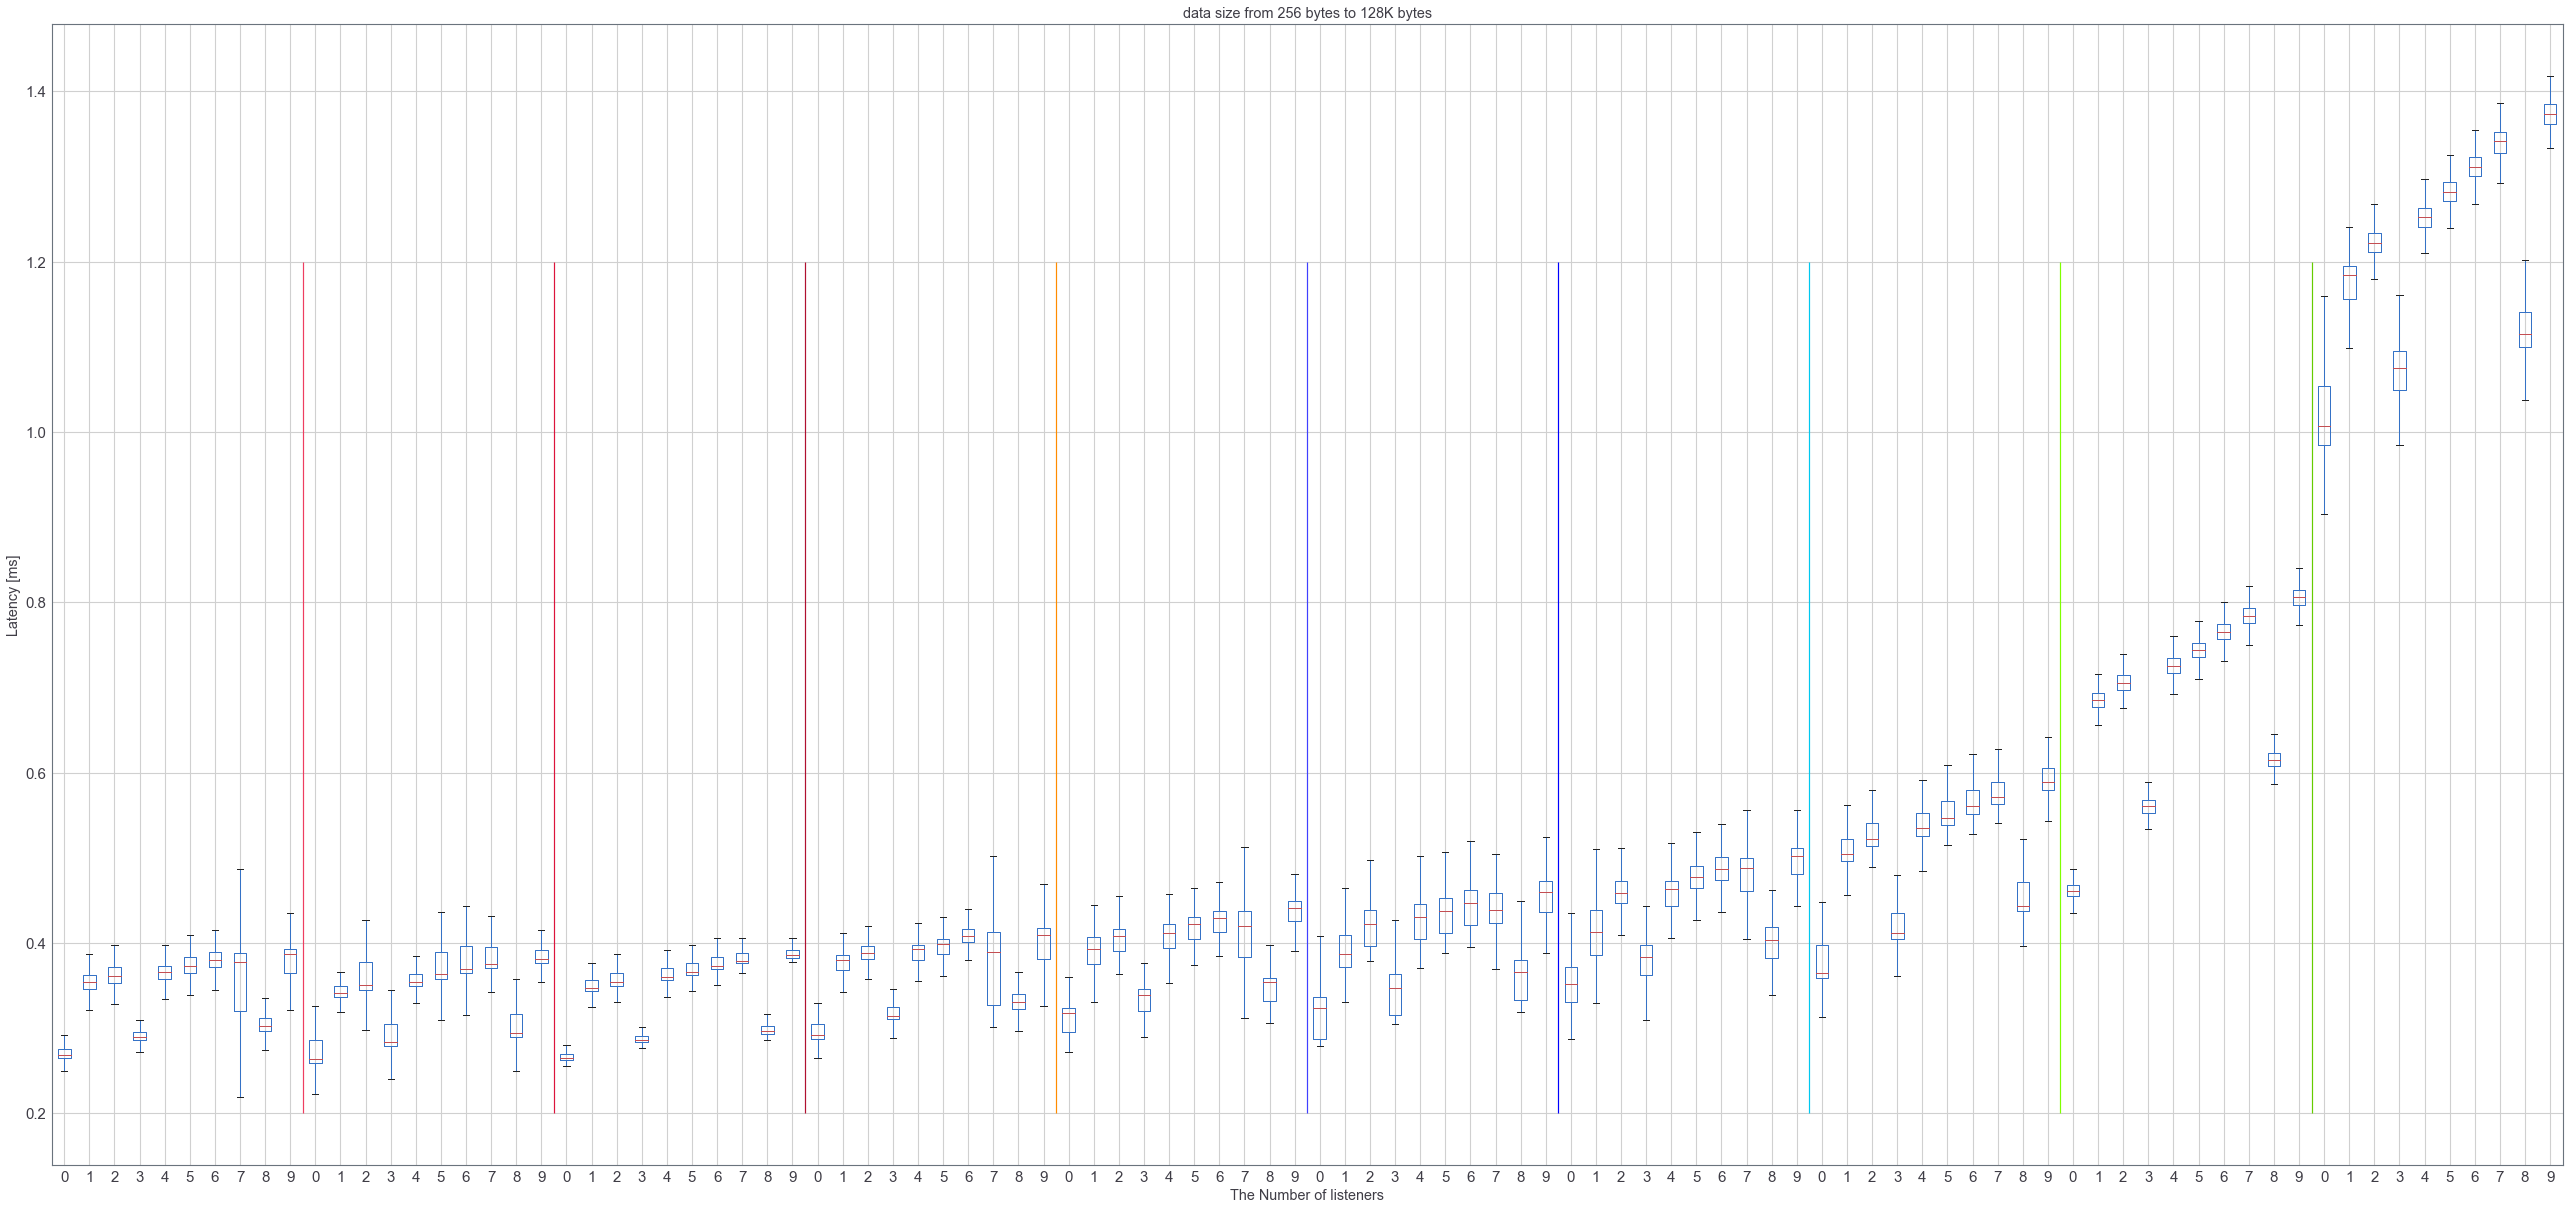

In [5]:
color = ['#ee3e61', '#dc143c', '#b01030', '#ff8c00', '#4040ff', '#0000ff', '#00c8f0', '#7fff00', '#66cc00']

plt.figure(num=1, figsize=(45,21))
boxplot = df_small.boxplot(fontsize=15, showfliers=False)
boxplot.set_ylabel("Latency [ms]")
boxplot.set_xlabel("The Number of listeners")
boxplot.set_title("data size from 256 bytes to 128K bytes")
for i in range(9):
    plt.vlines(10.5+i*10, 0.2, 1.2, colors=color[i])
plt.savefig('./q7/figure/q7_boxplot_small.pdf', dpi=1600)

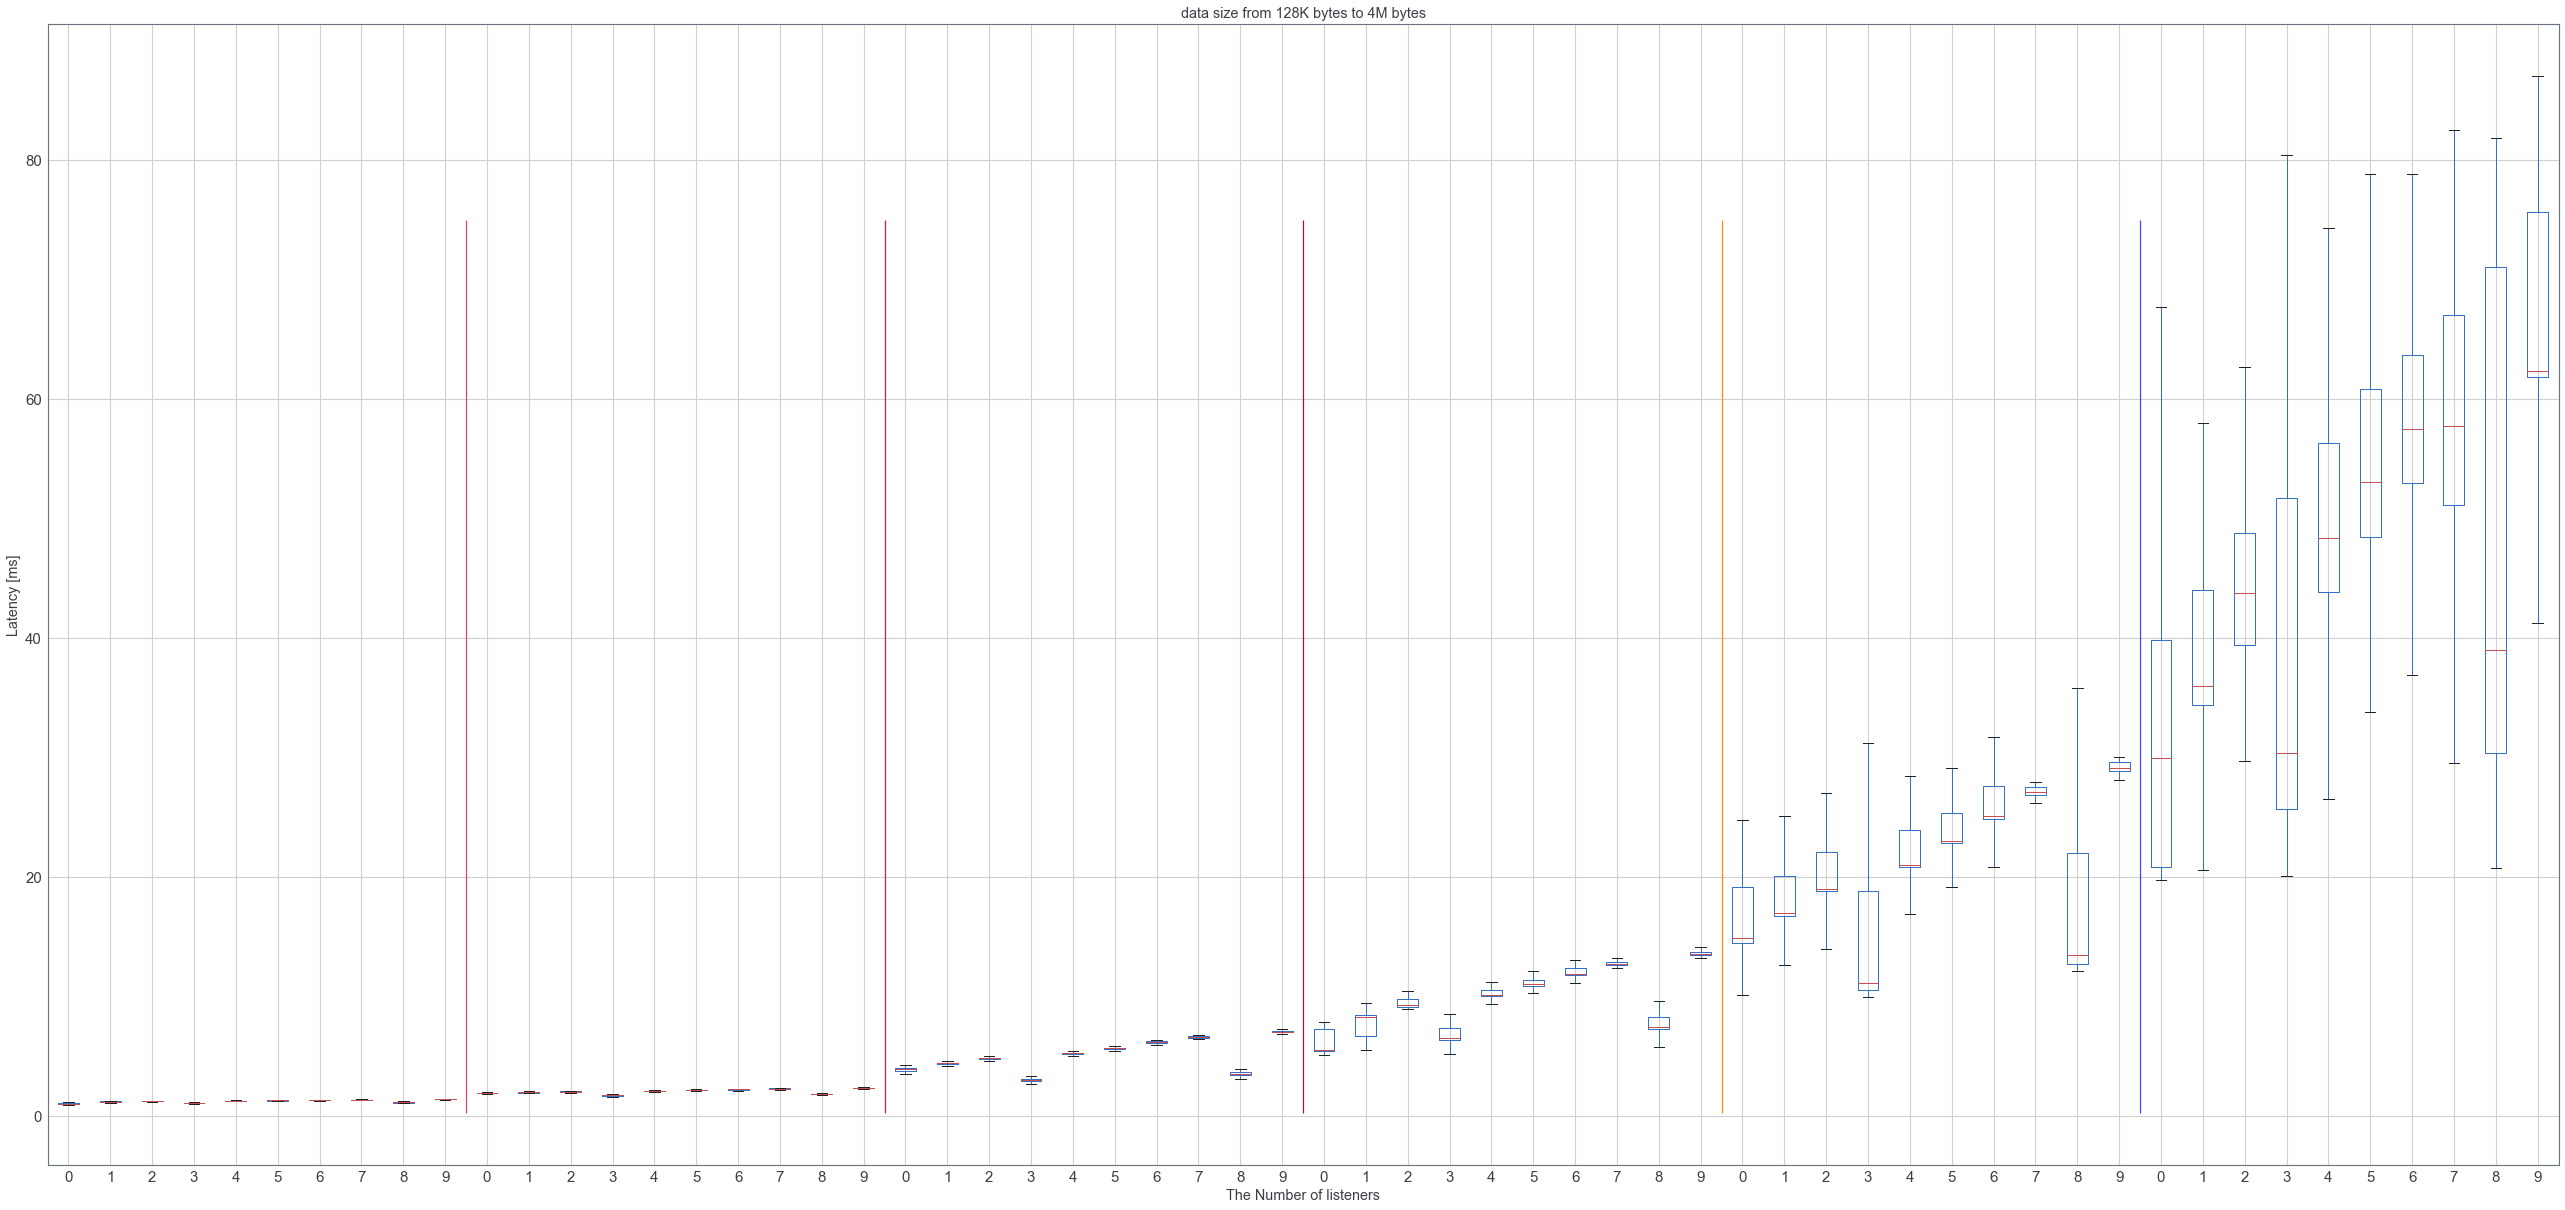

In [6]:
plt.figure(num=2, figsize=(45,21))
boxplot = df_large.boxplot(fontsize=15, showfliers=False)
boxplot.set_ylabel("Latency [ms]")
boxplot.set_xlabel("The Number of listeners")
boxplot.set_title("data size from 128K bytes to 4M bytes")
for i in range(5):
    plt.vlines(10.5+i*10, 0.2, 75, colors=color[i])
plt.savefig('./q7/figure/q7_boxplot_large.pdf', dpi=1600)

# ANOVA

In [7]:
np.hstack((df_256, df_512, df_1K, df_2K, df_4K, df_8K, df_16K, df_32K, df_64K, df_128K, df_256K, df_512K, df_1M, df_2M, df_4M)).shape

(570, 150)

In [8]:
anova = pd.DataFrame({
    "latency": np.hstack((df_256, df_512, df_1K, df_2K, df_4K, df_8K, df_16K, df_32K, df_64K, df_128K, df_256K, df_512K, df_1M, df_2M, df_4M)).flatten("F"),
    
    "Size": np.repeat(dataSize, 10*570),
    
    "Num_Listeners": np.r_[np.repeat(["1", "2", "3", "4", "5", "6", "7", "8", "9", "X"], 570),
                           np.repeat(["1", "2", "3", "4", "5", "6", "7", "8", "9", "X"], 570),
                           np.repeat(["1", "2", "3", "4", "5", "6", "7", "8", "9", "X"], 570),
                           np.repeat(["1", "2", "3", "4", "5", "6", "7", "8", "9", "X"], 570),
                           np.repeat(["1", "2", "3", "4", "5", "6", "7", "8", "9", "X"], 570),
                           np.repeat(["1", "2", "3", "4", "5", "6", "7", "8", "9", "X"], 570),
                           np.repeat(["1", "2", "3", "4", "5", "6", "7", "8", "9", "X"], 570),
                           np.repeat(["1", "2", "3", "4", "5", "6", "7", "8", "9", "X"], 570),
                           np.repeat(["1", "2", "3", "4", "5", "6", "7", "8", "9", "X"], 570),
                           np.repeat(["1", "2", "3", "4", "5", "6", "7", "8", "9", "X"], 570),
                           np.repeat(["1", "2", "3", "4", "5", "6", "7", "8", "9", "X"], 570),
                           np.repeat(["1", "2", "3", "4", "5", "6", "7", "8", "9", "X"], 570),
                           np.repeat(["1", "2", "3", "4", "5", "6", "7", "8", "9", "X"], 570),
                           np.repeat(["1", "2", "3", "4", "5", "6", "7", "8", "9", "X"], 570),
                           np.repeat(["1", "2", "3", "4", "5", "6", "7", "8", "9", "X"], 570)]
})

In [9]:
model_summary = rp.summary_cont(anova.groupby(['Size', 'Num_Listeners']))['latency']
model_summary

N    Mean      SD      SE  95% Conf.  Interval
Size Num_Listeners                                                  
128K 1              570  1.0274  0.0790  0.0033     1.0209    1.0339
     2              570  1.1653  0.0673  0.0028     1.1598    1.1709
     3              570  1.2364  0.3225  0.0135     1.2098    1.2629
     4              570  1.0550  0.1150  0.0048     1.0456    1.0645
     5              570  1.2556  0.1235  0.0052     1.2454    1.2658
...                 ...     ...     ...     ...        ...       ...
8K   6              570  0.4452  0.2181  0.0091     0.4273    0.4632
     7              570  0.4562  0.2568  0.0108     0.4351    0.4773
     8              570  0.4481  0.2966  0.0124     0.4237    0.4725
     9              570  0.3770  0.3376  0.0141     0.3492    0.4048
     X              570  0.4718  0.3715  0.0156     0.4412    0.5024

[150 rows x 6 columns]

In [10]:
model = ols('latency ~ C(Num_Listeners) + C(Size) + C(Num_Listeners)*C(Size)', anova).fit()

# Seeing if the overall model is significant
print(f"Overall model F({model.df_model: .0f},{model.df_resid: .0f}) = {model.fvalue: .3f}, p = {model.f_pvalue: .4f}")

Overall model F( 149, 85350) =  8320.499, p =  0.0000


In [11]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                latency   R-squared:                       0.936
Model:                            OLS   Adj. R-squared:                  0.935
Method:                 Least Squares   F-statistic:                     8320.
Date:                Sun, 13 Dec 2020   Prob (F-statistic):               0.00
Time:                        20:42:13   Log-Likelihood:            -2.2639e+05
No. Observations:               85500   AIC:                         4.531e+05
Df Residuals:                   85350   BIC:                         4.545e+05
Df Model:                         149                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept                                 1.0274      0.143      7.172      0.000       0.747       1.308
C(Num_Listeners)[T.2]                     0.1379      0.203      0.680      0.496      -0.259       0.535
C(Num_Listeners)[T.3]                     0.2089      0.203      1.031      0.302      -0.188       0.606
C(Num_Listeners)[T.4]                     0.0276      0.203      0.136      0.892      -0.370       0.425
C(Num_Listeners)[T.5]                     0.2281      0.203      1.126      0.260      -0.169       0.625
C(Num_Listeners)[T.6]                     0.2606      0.203      1.286      0.198      -0.136       0.658
C(Num_Listeners)[T.7]                     0.2968      0.203      1.465      0.143      -0.100       0.694
C(Num_Listeners)[T.8]                     0.3081      0.203      1.521      0.128      -0.089       0.705
C(Num_Listeners)[T.9]                     0.1009      0.203      0.498      0.619      -0.296       0.498
C(Num_Listeners)[T.X]                     0.3478      0.203      1.717      0.086      -0.049       0.745
C(Size)[T.16K]                           -0.6739      0.203     -3.326      0.001      -1.071      -0.277
C(Size)[T.1K]                            -0.7530      0.203     -3.716      0.000      -1.150      -0.356
C(Size)[T.1M]                             5.4142      0.203     26.722      0.000       5.017       5.811
C(Size)[T.256]                           -0.7505      0.203     -3.704      0.000      -1.148      -0.353
C(Size)[T.256K]                           1.5829      0.203      7.813      0.000       1.186       1.980
C(Size)[T.2K]                            -0.7148      0.203     -3.528      0.000      -1.112      -0.318
C(Size)[T.2M]                            14.8454      0.203     73.271      0.000      14.448      15.243
C(Size)[T.32K]                           -0.6405      0.203     -3.161      0.002      -1.038      -0.243
C(Size)[T.4K]                            -0.7148      0.203     -3.528      0.000      -1.112      -0.318
C(Size)[T.4M]                            30.4332      0.203    150.206      0.000      30.036      30.830
C(Size)[T.512]                           -0.7423      0.203     -3.664      0.000      -1.139      -0.345
C(Size)[T.512K]                           2.8520      0.203     14.076      0.000       2.455       3.249
C(Size)[T.64K]                           -0.5501      0.203     -2.715      0.007      -0.947      -0.153
C(Size)[T.8K]                            -0.7082      0.203     -3.496      0.000      -1.105      -0.311
C(Num_Listeners)[T.2]:C(Size)[T.16K]     -0.0759      0.287     -0.265      0.791      -0.638       0.486
C(Num_Listeners)[T.3]:C(Size)[T.16K]     -0.0978      0.287     -0.341      0.733      -0.659       0.464
C(Num_Lis

In [12]:
res = sm.stats.anova_lm(model, typ= 2)
res

,sum_sq,df,F,PR(>F)
C(Num_Listeners),1.398071e+05,9.0,1327.770963,0.0
C(Size),1.373698e+07,14.0,83868.631616,0.0
C(Num_Listeners):C(Size),6.275970e+05,126.0,425.742198,0.0
Residual,9.985439e+05,85350.0,NaN,NaN


In [13]:
res.to_latex()

'\\begin{tabular}{lrrrr}\n\\toprule\n{} &        sum\\_sq &       df &             F &  PR(>F) \\\\\n\\midrule\nC(Num\\_Listeners)         &  1.398071e+05 &      9.0 &   1327.770963 &     0.0 \\\\\nC(Size)                  &  1.373698e+07 &     14.0 &  83868.631616 &     0.0 \\\\\nC(Num\\_Listeners):C(Size) &  6.275970e+05 &    126.0 &    425.742198 &     0.0 \\\\\nResidual                 &  9.985439e+05 &  85350.0 &           NaN &     NaN \\\\\n\\bottomrule\n\\end{tabular}\n'